# Attend Infer Repeat

In this tutorial we will implement the "Attend Infer Repeat" (AIR) model[1] and apply it to the multi-mnist dataset.

<p style='border: 1px solid red; padding: 1em'>
Current status:

Pyro has everything needed to describe this model and inference strategy, but inference in our Pyro implementation of AIR is not yet working satisfactorily. We're still working on this, and will update this tutorial and the associated example as we make progress.
</p>

In [2]:
%pylab inline
import pyro
from pyro.distributions import Bernoulli, DiagNormal
from pyro.util import ng_zeros, ng_ones
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, grid_sample, affine_grid

Populating the interactive namespace from numpy and matplotlib


## Introduction

To get an idea where we're heading, we first give a brief overview of the model and the approach we'll take to inference.

AIR is a generative model of scenes. In this tutorial we will use it to model images from the multi-mnist dataset[1]. Here are some example data points from this data set:

`TODO: multi-mnist pictures`

AIR decomposes the process of generating a whole image into discrete steps, each of which generates part of the whole image. We'll call these parts "objects". In the case of AIR applied to the multi-mnist dataset we expect each of these objects to represent a single digit. Each object is represent as a latent "code" variable. This code is turned in to pixels by passing it through a neural network, which provides a flexible way of modelling the variability of individual digits. The model also includes uncertainty about the location and size of each object, and the number of objects within each image. Following the paper we'll call an object's location and size its "pose".

Inference in performed in this model using amortized variational inference. The parameters of the neural network are also be optimized during inference. Performing inference in such rich models is always difficult, but the presence of discrete choices (the number of steps in this case) makes inference in this model particularly tricky. For this reason the authors use a technique called data dependent baselines to achieve good performance. This technique can be implemented in Pyro, and we'll see how later in the tutorial.

## The Model

### Generating a single object

Let's look at the model more closely. At the core of the model is the generative process for a single object. Recall that:

* At each step a single object is generated.

* We maintain uncertainty about the latent code used to generate each
  object, as well as its pose.

* Each object is generated by passing its latent code through a neural
  network.

This can be expressed in Pyro like so:

In [3]:
# Create the neural network. This takes a latent code, z_what, to pixel intensities.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(50, 100)
        self.l2 = nn.Linear(100, 400)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decode = Decoder()
z_where_params = ...
z_what_params = ...

def model_step(t):
    # Sample object pose. This is a 3-vector representing x,y position and size.
    z_where = pyro.sample('z_where_{}'.format(t), DiagNormal(z_where_params))

    # Sample object code.
    z_what = pyro.sample('z_what_{}'.format(t), DiagNormal(z_what_params))
    
    # Map code to pixel space using the neural network.
    y_att = decode(z_what)

    # Position/scale object within larger image.
    y = object_to_image(z_where, object_size, x_size, y_att)

    return y

(Note that this code is only a sketch of an implementation that we will build up throughout the tutorial and is not executable. However a full [working example](https://github.com/uber/pyro/blob/dev/examples/air/air.py) is also available.)

Hopefully the use of `pyro.sample` and PyTorch networks within a model seem familiar at this point. If not you might want to review earlier parts of the tutorials. One thing to note is that we include the current step `t` in the name passed to `pyro.sample` to ensure that names are unique across steps.

The `object_to_image` function is specific to this model and warrants further attention. Recall that the neural network (`decode` here) will output a small image, and that we would like to add this to the output image after performing any translation and scaling required to achieve the pose (location and size) described by `z_where`. It's not clear how to do this, and in particular it's not obvious that this can be implemented in a way that preserves the differentiability of our model. However, it turns out we can do this this using a spatial transformer network (STN)[2].

Happily for us, PyTorch makes it easy to implement a STN using its [`grid_sample`](http://pytorch.org/docs/master/nn.html#grid-sample) and [`affine_grid`](http://pytorch.org/docs/master/nn.html#affine-grid) functions. `object_to_image` is a simple function that calls these, doing a little extra work to massage `z_where` into the expected format.

In [4]:
def expand_z_where(z_where):
    # Takes three vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = torch.LongTensor([1, 0, 2, 0, 1, 3])
    out = torch.cat((ng_zeros([1, 1]).type_as(z_where).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

A discussion of the details of the STN is beyond the scope of this tutorial. For our purposes however, it suffices to keep in mind that `object_to_image` takes the small image generated by the neural network and places it within a larger image with the desired pose.

### Generating an image

We have completed the implementation of the model for a single object. Next we need to consider how we use this to generate an entire image. Recall that we would like to maintain uncertainty over the number of steps used to generate each data point. To achieve this, we will sample from a Bernoulli distribution at each step and continue making further steps until we sample a `0`. By doing so, we specify a geometric prior over the number of steps.

However, at this point we run into a snag.

#### Vectorized mini-batches

In our final implementation we would like to generate a mini batch of samples in parallel for efficiency. While Pyro supports vectorized mini batches with `iarange`, it currently assumes that each sample statement within `iarange` samples a mini batch of the same size. This is problematic for us because as we have just described, each sample from our model can make a different number of choices.

One simple solution, and the one we'll take here, is to make a fixed number of steps for each sample, but only add the generated object to the final image when we sample a `1` from the Bernoulli distribution.

Even though this approach performs redundant computation, the gains from using mini batches are so large that this is still a win overall. (Eventually though, we'd like to be able to express the model in a way
that avoids this redundant computation.)

Putting this all together, the generative process for a single step looks something like this:

In [5]:
def model_step(n, t, prev_x, prev_z_pres):

    z_pres = pyro.sample('z_pres_{}'.format(t), Bernoulli(0.5 * prev_z_pres))

    # Sample attention window position.
    z_where = pyro.sample('z_where_{}'.format(t),
                          DiagNormal(
                              Variable(torch.Tensor([3, 0, 0])),
                              Variable(torch.Tensor([0.1, 1, 1])),
                              batch_size=n))

    # Sample latent code for contents of the attention window.
    z_what = pyro.sample('z_what_{}'.format(t),
                         DiagNormal(ng_zeros(50), ng_ones(50), batch_size=n))

    # Map latent code to pixel space.
    y_att = decode(z_what)

    # Position/scale attention window within larger image.
    y = object_to_image(z_where, y_att)

    # Combine the image generated at this step with the image so far.
    # (Note that there's no notion of occlusion here. Overlapping
    # objects can create pixel intensities > 1.)
    x = prev_x + y * z_pres.view(-1, 1, 1)

    return x, z_pres

By iterating this step function we can produce an entire image, composed of multiple objects. Since each image in the multi-mnist dataset contains zero, one or two digits we will allow the model to use up to (and including) three steps. This will allow us to observe whether inference avoids using the unnecessary final step, and to test the model's ability to generalize to images with more digits than are present in the dataset.

The final step of the generative process adds a small amount of Gaussian noise to each pixel. (TODO: Say more about this.)

In [6]:
def prior(n):
    x = ng_zeros(50, 50)
    z_pres = ng_ones(n, 1)
    for t in range(3):
        x, z_pres = model_step(n, t, x, z_pres)
    return x#pyro.sample('obs', DiagNormal(x.view(n, -1), 0.3 * ng_ones(1, 1)))

This completes the implementation of the model. Let's vizualize some samples to get a feel for the prior we have specified:

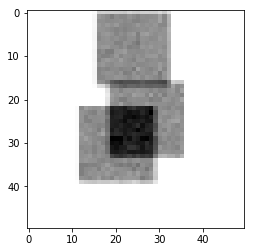

In [61]:
samples = prior(1)
imshow(samples.view(50, 50).data.numpy(), cmap='binary')

## The Guide

Following the paper we will perform amortized variational inference in this model. (LINK: tutorial) Pyro provides general purpose machinery that implements most of this inference strategy, but as we have seen in earlier tutorials we are required to provide a model specific guide. What we call a guide in Pyro is exactly the entity called the "inference network" in the paper.

Let's think about how to structure a guide network to take a multi-mnist image as input and produce the parameters of the latent choices in the model as output. Recall that the model is split into a number of discrete steps, it is therefore natural to structure the network as a recurrent network. At each step the recurrent network will generate the parameters for the choices made within the step. The values sampled will be fed back into the recurrent network so that this information can be used when computing the parameters for the next
step. (LINK: similar to dmm. link?)

This can be implemented in Pyro like so:

In [7]:
# TODO: code, no attn window yet

This would be a reasonable guide to use with this model, but the paper describes a crucial improvement we can make to the code above. Recall that the guide will output information about an object's pose and its latent code at each step. The improvement we can make is based on the observation that once we have computed the pose of an object, we can do a better job of computing its latent code if we use the pose information to crop the object from the input image, and feed the result (which we'll call the "window") into the network as an additional input.

Here's how we can implement this in Pyro:

In [9]:
# TODO: code

Since we want to maintain differentiability of the guide we again use a STN to perform the required "cropping". The `image_to_object` function performs the opposite transform to the `object_to_image` function used in the guide. That is, the former takes a small image and places it on a larger image, and the latter crops a small image from a larger image.

See figure 3b of [1] for a picture of the final guide structure.

### Another perspective

So far we've considered the model and the guide in isolation, but we gain an interesting perspective if we zoom out and look at the model and guide computation as a whole. Doing so, we see that at each step AIR includes a sub-computation that has the same structure as a Variational Auto-encoder (VAE). (LINK: vae tutorial.)

To see this, notice that the guide passes the window through a neural network (the encoder) to generate the parameters of the distribution over a latent code, and the model passes samples from this latent code distribution through another neural network (the decoder) to generate an output window.

From this perspective AIR is seen as a sequential variant of the VAE. The act of cropping a small window from the input image serves to restrict the attention of a VAE to a small region of the input image at each step; hence "Attend, Infer, Repeat".

## Inference

As was mentioned in the introduction, successfully performing inference in this model is a challenge. In particular, the presence of discrete choices in the model makes inference trickier than in a model in which all choices are continuous.

(LINK: Link to tutorial discussion of combined estimator, trickiness of reinforce.)

The underlying problem we face is that the gradient estimates we use in the optimization performed by variational inference have much higher variance in the presence of discrete choices.

To bring this variance under control, the paper applies a technique called "data dependent baselines" (AKA "neural baselines") to the discrete choices in the model. Happily for us Pyro includes support for this technique which means we don't have to do too much work to add this to our model. If you are not already familiar with this idea, you might want to read our introduction before continuing. (LINK: tutorial)

### Data dependent baselines

Pyro includes support for data dependent baselines. As model authors we only have to implement the neural network, pass it our data as input, and feed its output to `pyro.sample`. Pyro's inference back-end will ensure that the baseline is included in the gradient estimator used for inference, and that the network parameters are updated appropriately.

Let's see how we can add data dependent baselines to our AIR implementation. We need a neural network that can output a (scalar) baseline value at each discrete choice in the guide, having received a multi-mnist image and the values sampled by the guide so far as input. Notice that this is very similar to the structure of the guide network, and indeed we will again use a recurrent network.

Here's the guide program for a single step, updated to include the baseline network:

In [10]:
# TODO: code

There a few details to attend to in order to make this work.

First, notice that in the code we `detach` values sampled by the guide before passing them to the baseline network. This is important as the baseline network and the guide network are entirely separate networks optimized with different objectives. Without this, gradients would flow from the baseline network in to the guide network. When using data dependent baselines we must do this whenever we feed values sampled by the guide into the baselines network. (If we don't we'll trigger a PyTorch run-time error.)

Second, it might be useful in practice to use different learning rates for the parameters of these two networks. For AIR a learning rate of `1e-4` is used for the guide network, and a learning rate of `1e-3` is used for the baseline network. This is easy to implement in Pyro by tagging modules (LINK: modules tagging docs) associated with the baseline network and passing multiple learning rates to the optimizer.


### Putting it altogether

We have now completed the implementation of the model and the guide. To perform inference we only need to write a few more lines of code to hand these over to Pyro and to specify which inference algorithm we would like to use.

In [11]:
# TODO: code

This says that we are performing stochastic variational inference (SVI) and specifies the learning rates for the guide and baseline network as mentioned earlier.

Notice that we pass the `trace_graph=True` option to `SVI`. This enables a more sophisticated gradient estimator that further reduces the variance of gradient estimates by making use if independence information included in the model. Using the feature is essential to achieving good results in the presence of discrete choices. You can read more about it in (LINK: to appropriate bit of tutorial.)

## References

[1] `Attend, Infer, Repeat: Fast Scene Understanding with Generative Models`
<br />&nbsp;&nbsp;&nbsp;&nbsp;
Eslami, SM Ali and Heess, Nicolas and Weber, Theophane and Tassa, Yuval and Szepesvari, David and Hinton, Geoffrey E

[2] `Spatial Transformer Networks`
<br />&nbsp;&nbsp;&nbsp;&nbsp;
Jaderberg, Max and Simonyan, Karen and Zisserman, Andrew